## Target guided encodings

[Feature Engineering for Machine Learning Course](https://www.trainindata.com/p/feature-engineering-for-machine-learning)

There are encoding methods that allow us to capture information while pre-processing the categories of the variables. These methods include:

- Ordering the labels according to the target
- Replacing labels by the target mean (mean encoding / target encoding)
- Weight of evidence.

All of the above methods have something in common:

- the encoding is **guided by the target**, and
- they create a **monotonic relationship** between the variable and the target.


### Monotonicity

A monotonic relationship is a relationship that does one of the following:

- (1) as the value of one variable increases, so does the value of the other variable; or
- (2) as the value of one variable increases, the value of the other variable decreases.

In this case, as the value of the independent variable (predictor) increases, so does the target, or conversely, as the value of the variable increases, the target value decreases.


### Advantages of target guided encodings

- Capture the predictive value of each category.
- Create a monotonic relationship between the variable and the target
    - Create features suitable for linear models
- Do not expand the feature space


### Note

These methods can be also used on numerical variables, after discretisation. This creates a monotonic relationship between the numerical variable and the target, and therefore improves the performance of linear models. I will discuss this in more detail in the section "Discretisation".

===============================================================================

## Ordered Ordinal Encoding

Ordering the categories according to the target means assigning a number to the category from 1 to k, where k is the number of distinct categories in the variable, but this numbering is informed by the mean of the target for each category.

For example, we have the variable city with values London, Manchester and Bristol; if the default rate is 30% in London, 20% in Bristol and 10% in Manchester, then we replace London by 1, Bristol by 2 and Manchester by 3.

## In this demo:

We will see how to perform one hot encoding with pandas using the House Prices dataset.

For guidelines to obtain the dataset, visit **section 2** of the course.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# load dataset

data = pd.read_csv(
    "../../Datasets/houseprice.csv",
    usecols=["Neighborhood", "Exterior1st", "Exterior2nd", "SalePrice"],
)

data.head()

,Neighborhood,Exterior1st,Exterior2nd,SalePrice
0,CollgCr,VinylSd,VinylSd,208500
1,Veenker,MetalSd,MetalSd,181500
2,CollgCr,VinylSd,VinylSd,223500
3,Crawfor,Wd Sdng,Wd Shng,140000
4,NoRidge,VinylSd,VinylSd,250000


In [3]:
# let's have a look at how many labels each variable has

for col in data.columns:
    print(f"{col}: {data[col].nunique()} labels")

Neighborhood: 25 labels
Exterior1st: 15 labels
Exterior2nd: 16 labels
SalePrice: 663 labels


In [4]:
# let's explore the unique categories

data["Neighborhood"].unique()

array(['CollgCr', 'Veenker', 'Crawfor', 'NoRidge', 'Mitchel', 'Somerst',
       'NWAmes', 'OldTown', 'BrkSide', 'Sawyer', 'NridgHt', 'NAmes',
       'SawyerW', 'IDOTRR', 'MeadowV', 'Edwards', 'Timber', 'Gilbert',
       'StoneBr', 'ClearCr', 'NPkVill', 'Blmngtn', 'BrDale', 'SWISU',
       'Blueste'], dtype=object)

In [5]:
data["Exterior1st"].unique()

array(['VinylSd', 'MetalSd', 'Wd Sdng', 'HdBoard', 'BrkFace', 'WdShing',
       'CemntBd', 'Plywood', 'AsbShng', 'Stucco', 'BrkComm', 'AsphShn',
       'Stone', 'ImStucc', 'CBlock'], dtype=object)

In [6]:
data["Exterior2nd"].unique()

array(['VinylSd', 'MetalSd', 'Wd Shng', 'HdBoard', 'Plywood', 'Wd Sdng',
       'CmentBd', 'BrkFace', 'Stucco', 'AsbShng', 'Brk Cmn', 'ImStucc',
       'AsphShn', 'Stone', 'Other', 'CBlock'], dtype=object)

### Encoding important

We select which digit to assign each category using the train set, and then use those mappings in the test set.

In [7]:
# let's separate into training and testing set

X_train, X_test, y_train, y_test = train_test_split(
    data[["Neighborhood", "Exterior1st", "Exterior2nd"]],
    data["SalePrice"],  # target
    test_size=0.3,  # percentage of obs in test set
    random_state=0,
)  # seed to ensure reproducibility

X_train.shape, X_test.shape

((1022, 3), (438, 3))

### Explore original relationship between categorical variables and target

In [25]:
# omd
from sklearn.base import BaseEstimator, TransformerMixin

class OrdinalEncoding(BaseEstimator, TransformerMixin):
    def __init__(self, variables):
        self.variables = variables

    def fit(self, X, y):
        self.mapping_dict_collection = []
        for var in self.variables:
            self.ordered_list = y.groupby(X[var]).mean().sort_values(ascending=True).index
            self.ordered_mapping_dict = {j: i for i, j in enumerate(self.ordered_list, 0)}
            self.mapping_dict_collection.append(self.ordered_mapping_dict)
        return self
    
    def transform(self, X, y=None):
        X = X.copy()
        for i, var in enumerate(self.variables):
            X[var] = X[var].map(self.mapping_dict_collection[i])
        return X 
    
    def fit_transform(self, X, y):
        return self.fit(X, y).transform(X)

In [26]:
# omd
train = X_train.copy()
test = X_test.copy()
oe = OrdinalEncoding(variables=["Neighborhood", "Exterior1st", "Exterior2nd"])
train = oe.fit_transform(train, y_train)
test = oe.transform(test)

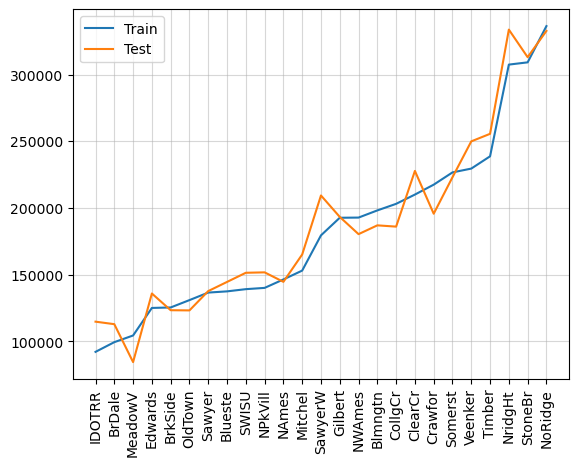

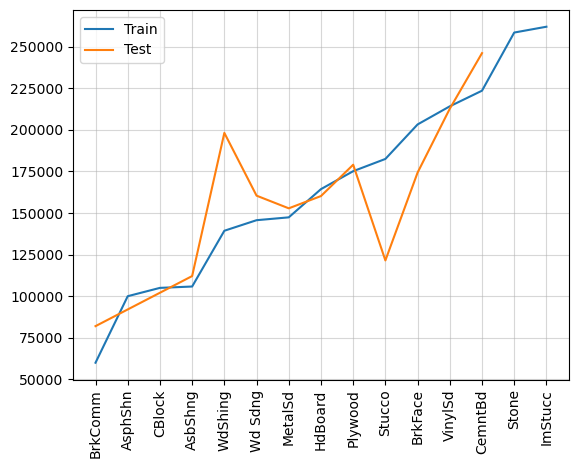

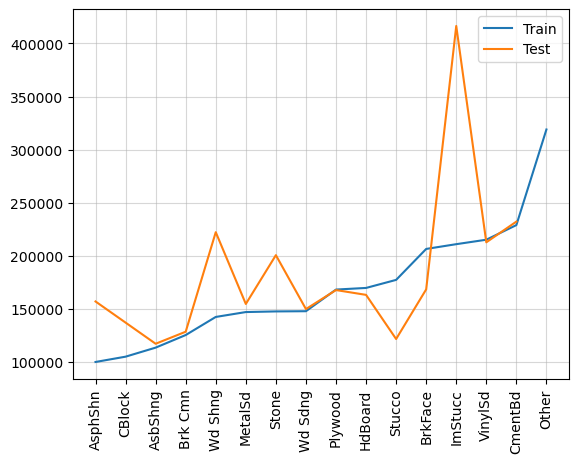

In [27]:
# omd
for i, var in enumerate(["Neighborhood", "Exterior1st", "Exterior2nd"]):
    plt.plot(y_train.groupby(train[var]).mean(), label='Train')
    plt.plot(y_test.groupby(test[var]).mean(), label='Test')
    plt.xticks(range(len(oe.mapping_dict_collection[i])), oe.mapping_dict_collection[i])
    plt.xticks(rotation=90)
    plt.legend()
    plt.grid(True, alpha=0.5)
    plt.show()

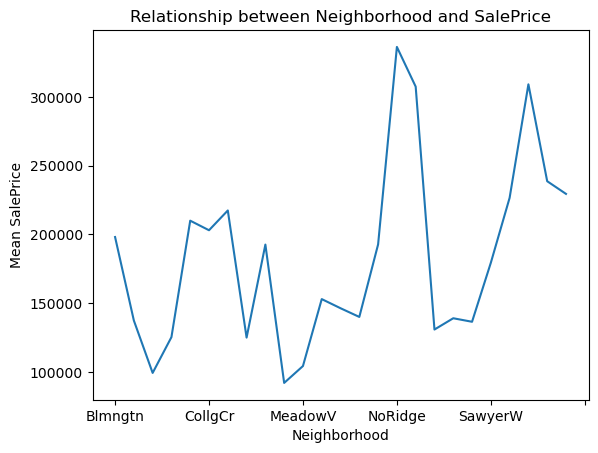

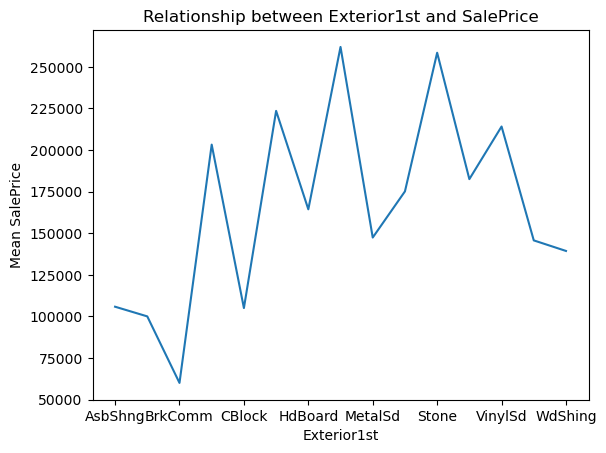

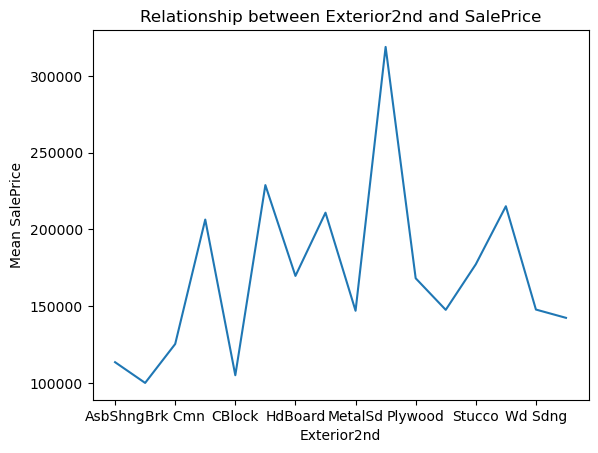

In [42]:
# let's explore the relationship of the categories with the target

for var in ["Neighborhood", "Exterior1st", "Exterior2nd"]:

    fig = plt.figure()
    fig = y_train.groupby(X_train[var]).mean().plot()
    fig.set_title("Relationship between {} and SalePrice".format(var))
    fig.set_ylabel("Mean SalePrice")
    plt.show()

You can see that the relationship between the target and the categories of the categorical variables goes up and down, depending on the category.


## Ordered Ordinal encoding with pandas


### Advantages

- quick
- returns pandas dataframe

### Limitations of pandas:

- it does not preserve information from train data to propagate to test data

We need to store the encoding maps separately if planing to use them in production.

In [10]:
# let's order the labels according to the mean target value

y_train.groupby(X_train["Neighborhood"]).mean().sort_values()

Neighborhood
IDOTRR      92174.166667
BrDale      99440.000000
MeadowV    104441.666667
Edwards    125082.676056
BrkSide    125438.414634
OldTown    130958.328767
Sawyer     136596.442623
Blueste    137500.000000
SWISU      139154.666667
NPkVill    140107.142857
NAmes      146435.264901
Mitchel    153070.444444
SawyerW    179463.088889
Gilbert    192662.290909
NWAmes     192788.235294
Blmngtn    198164.500000
CollgCr    203086.371429
ClearCr    210034.666667
Crawfor    217453.914286
Somerst    226644.196429
Veenker    229500.000000
Timber     238700.100000
NridgHt    307418.137255
StoneBr    309105.937500
NoRidge    336264.666667
Name: SalePrice, dtype: float64

In the above cell, we ordered the categories from the neighbourhood where the houses sale prices are cheaper (IDOTRR), to the neighbourhood where the house prices are, on average, more expensive (NoRidge).

In the next cells, we will replace those categories, ordered as they are, by the numbers 0 to k, where k is the number of different categories minus 1, in this case 25 - 1 = 24.

So IDOTRR will be replaced by 0 and NoRidge by 24, just to be clear.

In [11]:
# first  we generate an ordered list with the labels

ordered_labels = y_train.groupby(X_train["Neighborhood"]).mean().sort_values().index

ordered_labels

Index(['IDOTRR', 'BrDale', 'MeadowV', 'Edwards', 'BrkSide', 'OldTown',
       'Sawyer', 'Blueste', 'SWISU', 'NPkVill', 'NAmes', 'Mitchel', 'SawyerW',
       'Gilbert', 'NWAmes', 'Blmngtn', 'CollgCr', 'ClearCr', 'Crawfor',
       'Somerst', 'Veenker', 'Timber', 'NridgHt', 'StoneBr', 'NoRidge'],
      dtype='object', name='Neighborhood')

In [12]:
# next let's create a dictionary with the mappings of categories to numbers

ordinal_mapping = {k: i for i, k in enumerate(ordered_labels, 0)}

ordinal_mapping

{'IDOTRR': 0,
 'BrDale': 1,
 'MeadowV': 2,
 'Edwards': 3,
 'BrkSide': 4,
 'OldTown': 5,
 'Sawyer': 6,
 'Blueste': 7,
 'SWISU': 8,
 'NPkVill': 9,
 'NAmes': 10,
 'Mitchel': 11,
 'SawyerW': 12,
 'Gilbert': 13,
 'NWAmes': 14,
 'Blmngtn': 15,
 'CollgCr': 16,
 'ClearCr': 17,
 'Crawfor': 18,
 'Somerst': 19,
 'Veenker': 20,
 'Timber': 21,
 'NridgHt': 22,
 'StoneBr': 23,
 'NoRidge': 24}

In [13]:
# now, we replace the labels with the integers

X_train["Neighborhood"] = X_train["Neighborhood"].map(ordinal_mapping)
X_test["Neighborhood"] = X_test["Neighborhood"].map(ordinal_mapping)

In [14]:
# let's explore the result

X_train["Neighborhood"].head(10)

64      16
682     17
960      4
1384     3
1100     8
416      6
1034    18
853     10
472      3
1011     3
Name: Neighborhood, dtype: int64

In [15]:
# we can turn the previous commands into 2 functions


def find_category_mappings(df, variable, target):

    # first  we generate an ordered list with the labels
    ordered_labels = target.groupby(df[variable]).mean().sort_values().index

    # return the dictionary with mappings
    return {k: i for i, k in enumerate(ordered_labels, 0)}


def integer_encode(train, test, variable, ordinal_mapping):

    train[variable] = train[variable].map(ordinal_mapping)
    test[variable] = test[variable].map(ordinal_mapping)

In [16]:
# and now we run a loop over the remaining categorical variables

for variable in ["Exterior1st", "Exterior2nd"]:

    mappings = find_category_mappings(X_train, variable, y_train)

    integer_encode(X_train, X_test, variable, mappings)

In [17]:
# let's see the result

X_train.head()

,Neighborhood,Exterior1st,Exterior2nd
64,16,11,13
682,17,5,7
960,4,5,8
1384,3,4,4
1100,8,5,7


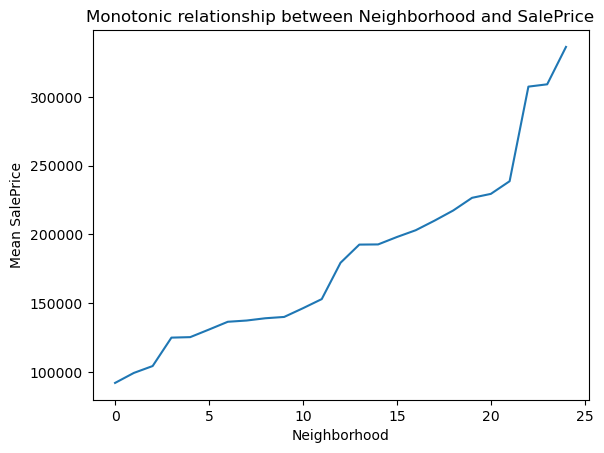

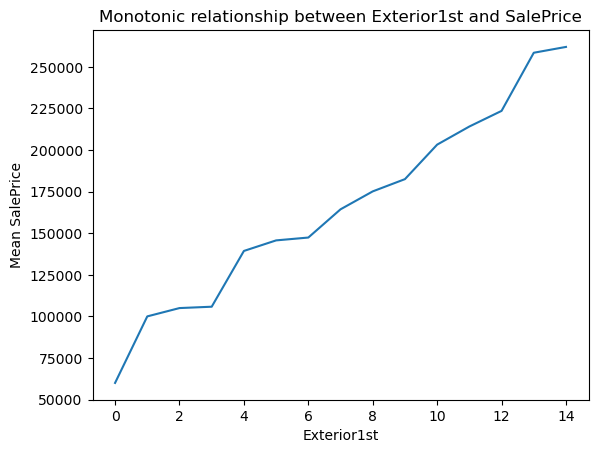

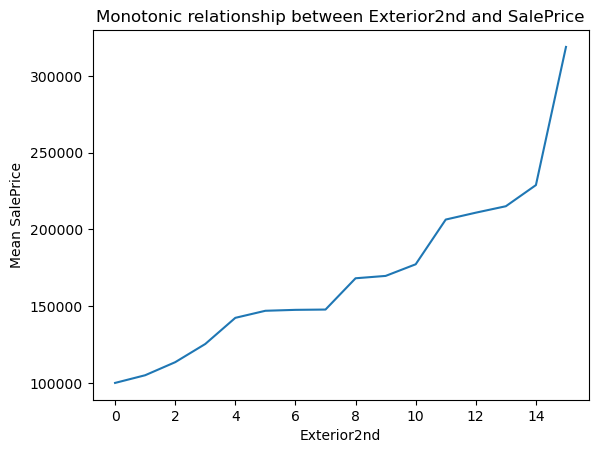

In [18]:
# let's inspect the newly created monotonic relationship
# between the variables and the target

for var in ["Neighborhood", "Exterior1st", "Exterior2nd"]:

    fig = plt.figure()
    fig = y_train.groupby(X_train[var]).mean().plot()
    fig.set_title("Monotonic relationship between {} and SalePrice".format(var))
    fig.set_ylabel("Mean SalePrice")
    plt.show()

We see from the plots above that the relationship between the categories and the target is now monotonic, and for the first 2 variables, almost linear, which helps improve linear models performance.

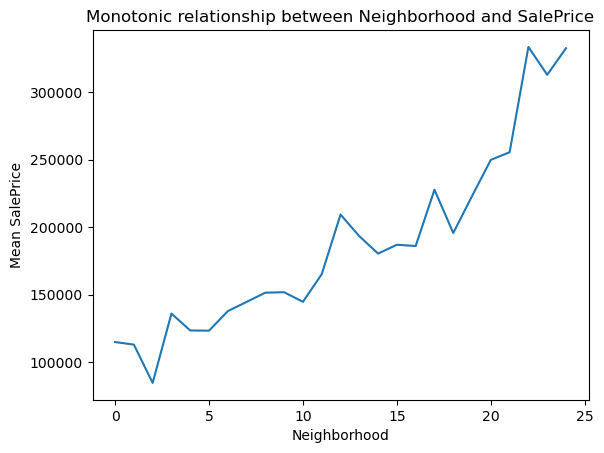

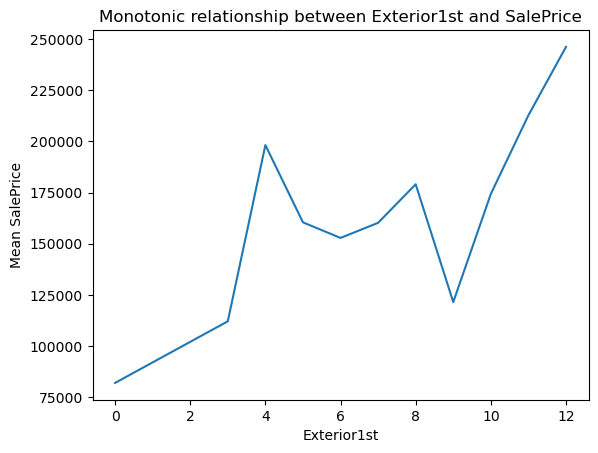

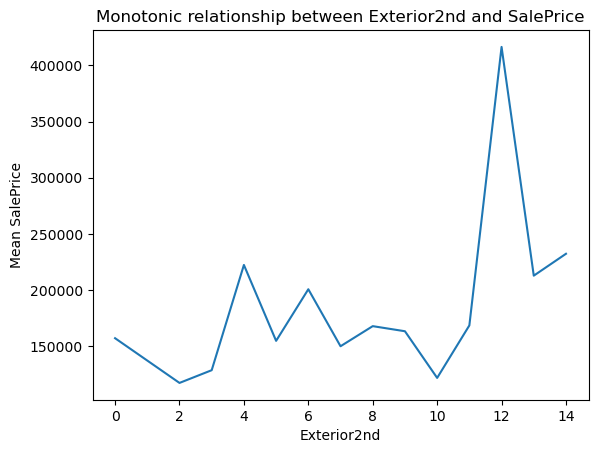

In [19]:
# let's inspect the newly created monotonic relationship
# between the variables and the target

for var in ["Neighborhood", "Exterior1st", "Exterior2nd"]:

    fig = plt.figure()
    fig = y_test.groupby(X_test[var]).mean().plot()
    fig.set_title("Monotonic relationship between {} and SalePrice".format(var))
    fig.set_ylabel("Mean SalePrice")
    plt.show()

The monotonicity in the test set is somewhat lost, which means that this encoding method may cause over-fitting when training a model.